In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/drive/MyDrive/cybersecurity_attacks.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [ ]:
print("Dataset Head:\n", data.head())
print("\nDataset Info:\n")
data.info()
print("\nDataset Description:\n", data.describe())

Dataset Head:
              Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ... Action Taken 

In [ ]:
columns_to_use = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.sort_values('Timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[columns_to_use])

In [ ]:
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        sequences.append(seq)
    return np.array(sequences)

time_steps = 30
sequences = create_sequences(data_normalized, time_steps)

In [ ]:
input_dim = sequences.shape[2]
inputs = Input(shape=(time_steps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
encoded = RepeatVector(time_steps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [ ]:
train_size = int(0.8 * len(sequences))
X_train = sequences[:train_size]
X_test = sequences[train_size:]

history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, validation_split=0.1, shuffle=True)


Epoch 1/20
450/450 [==============================] - 20s 38ms/step - loss: 0.0925 - val_loss: 0.0822
Epoch 2/20
450/450 [==============================] - 19s 42ms/step - loss: 0.0803 - val_loss: 0.0807
Epoch 3/20
450/450 [==============================] - 18s 40ms/step - loss: 0.0791 - val_loss: 0.0795
Epoch 4/20
450/450 [==============================] - 15s 34ms/step - loss: 0.0779 - val_loss: 0.0780
Epoch 5/20
450/450 [==============================] - 18s 40ms/step - loss: 0.0764 - val_loss: 0.0766
Epoch 6/20
450/450 [==============================] - 16s 37ms/step - loss: 0.0750 - val_loss: 0.0755
Epoch 7/20
450/450 [==============================] - 18s 40ms/step - loss: 0.0741 - val_loss: 0.0748
Epoch 8/20
450/450 [==============================] - 18s 39ms/step - loss: 0.0733 - val_loss: 0.0736
Epoch 9/20
450/450 [==============================] - 16s 35ms/step - loss: 0.0725 - val_loss: 0.0728
Epoch 10/20
450/450 [==============================] - 18s 39ms/step - loss: 0.071

In [ ]:
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.mean(np.square(X_test - reconstructed), axis=2), axis=1)

250/250 [==============================] - 3s 11ms/step


In [ ]:
thresholds = {
    "Highly likely normal": np.percentile(mse, 50),
    "Generally normal but unusual": np.percentile(mse, 75),
    "Potentially anomalous": np.percentile(mse, 95),
    "Very likely anomalous": np.max(mse)
}

def classify_error(error):
    if error <= thresholds["Highly likely normal"]:
        return "Highly likely normal"
    elif error <= thresholds["Generally normal but unusual"]:
        return "Generally normal but unusual"
    elif error <= thresholds["Potentially anomalous"]:
        return "Potentially anomalous"
    else:
        return "Very likely anomalous"

categories = [classify_error(err) for err in mse]

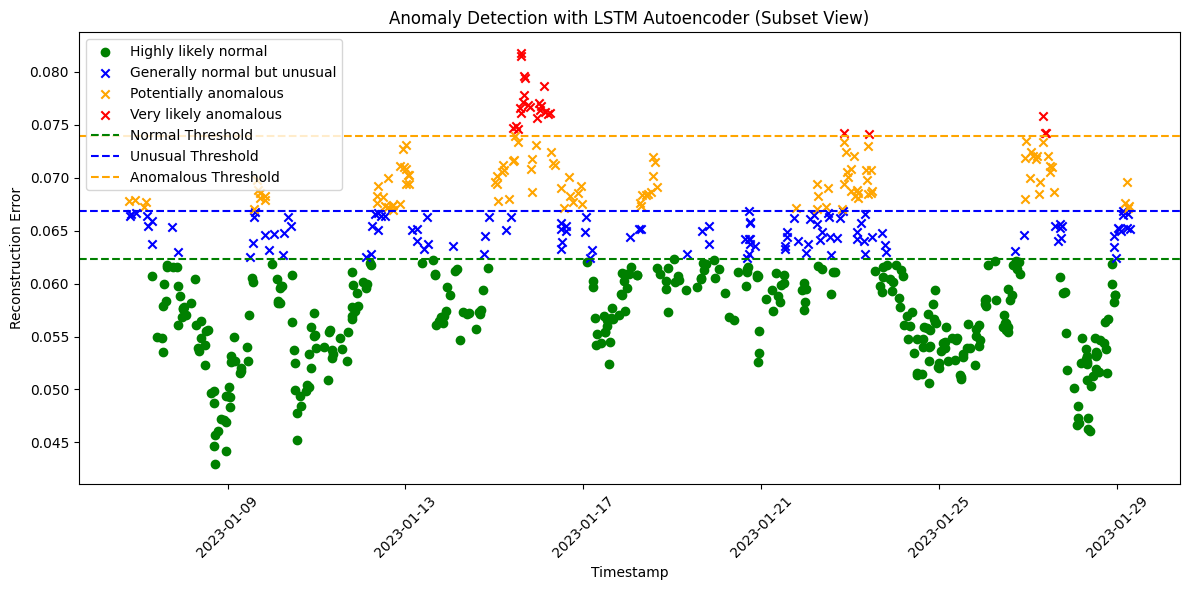

In [ ]:
timestamps = data['Timestamp'][train_size + time_steps:].reset_index(drop=True)
subset_size = 600
subset_indices = range(subset_size)
subset_timestamps = timestamps.iloc[subset_indices]
subset_mse = mse[subset_indices]
subset_categories = [categories[i] for i in subset_indices]

plt.figure(figsize=(12, 6))
colors = {
    "Highly likely normal": 'green',
    "Generally normal but unusual": 'blue',
    "Potentially anomalous": 'orange',
    "Very likely anomalous": 'red'
}
markers = {
    "Highly likely normal": 'o',
    "Generally normal but unusual": 'x',
    "Potentially anomalous": 'x',
    "Very likely anomalous": 'x'
}

for category in colors.keys():
    indices = [i for i, cat in enumerate(subset_categories) if cat == category]
    plt.scatter(subset_timestamps.iloc[indices], subset_mse[indices], c=colors[category], label=category, marker=markers[category])

plt.axhline(y=thresholds["Highly likely normal"], color='green', linestyle='--', label='Normal Threshold')
plt.axhline(y=thresholds["Generally normal but unusual"], color='blue', linestyle='--', label='Unusual Threshold')
plt.axhline(y=thresholds["Potentially anomalous"], color='orange', linestyle='--', label='Anomalous Threshold')
plt.title('Anomaly Detection with LSTM Autoencoder (Subset View)')
plt.xlabel('Timestamp')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
results = pd.DataFrame({
    "Timestamp": timestamps,
    "Reconstruction Error": mse,
    "Category": categories
})

print("Anomalies by Category:")
print(results[results['Category'] != "Highly likely normal"].head())




Anomalies by Category:
            Timestamp  Reconstruction Error                      Category
0 2023-01-06 18:42:38              0.067773         Potentially anomalous
1 2023-01-06 19:20:13              0.066425  Generally normal but unusual
2 2023-01-06 19:52:34              0.066591  Generally normal but unusual
3 2023-01-06 22:14:14              0.067895         Potentially anomalous
4 2023-01-06 22:38:04              0.066639  Generally normal but unusual


In [ ]:
from sklearn.metrics import accuracy_score
threshold_anomaly = np.percentile(mse, 95)
true_labels = np.array([1 if err > threshold_anomaly else 0 for err in mse])
predicted_labels = [1 if cat in ["Potentially anomalous", "Very likely anomalous"] else 0 for cat in categories]
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.6f}')


Accuracy: 0.799975


In [ ]:
anomalous_indices = [i for i, cat in enumerate(categories) if cat in ["Potentially anomalous", "Very likely anomalous"]]
adjusted_indices = [train_size + time_steps + i for i in anomalous_indices]
anomalous_data = data.iloc[adjusted_indices].copy()
anomalous_data['Anomaly_Score'] = [mse[i] for i in anomalous_indices]  # Add reconstruction errors as anomaly scores
output_file = "exported_anomalies.csv"
anomalous_data.to_csv(output_file, index=False)
print(f"Anomalous data successfully exported to {output_file}")


Anomalous data successfully exported to exported_anomalies.csv
